# Sample of Evaluation of ObjectDetection

|Item|Description|
|---|---|
|DeepLearning Framework|PyTorch|
|Dataset|COCO2014|
|Model Architecture|SSD|

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#!pip install pycocotools==2.0.7

In [3]:
import os
import random
import numpy as np
import pandas as pd
import json
import cv2
from pathlib import Path
from PIL import Image
from tqdm import tqdm

import torch
import torchvision

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

## Set Random Seed

In [4]:
seed=42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## Device Settings

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Preparing Dataset

In [6]:
root = '/tmp/dataset'

In [7]:
if (not Path(root, 'train2014.zip').exists()):
    !wget -q http://images.cocodataset.org/zips/train2014.zip -P {root}
    !unzip -q {root}/'train2014.zip' -d {root}
if (not Path(root, 'val2014.zip').exists()):
    !wget -q http://images.cocodataset.org/zips/val2014.zip -P {root}
    !unzip -q {root}/'val2014.zip' -d {root}
if (not Path(root, 'annotations_trainval2014.zip').exists()):
    !wget -q http://images.cocodataset.org/annotations/annotations_trainval2014.zip -P {root}
    !unzip -q {root}/'annotations_trainval2014.zip' -d {root}

In [8]:
with open(f'{root}/annotations/instances_val2014.json', 'r') as f:
    instances = json.load(f)
df_images = pd.DataFrame(instances['images'])
df_categories = pd.DataFrame(instances['categories'])
df_annotations = pd.DataFrame(instances['annotations'])

## Load Pretrained Model

In [9]:
model = torchvision.models.detection.ssd300_vgg16(weights=torchvision.models.detection.ssd.SSD300_VGG16_Weights.COCO_V1)
#model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd')
model.to(device)
model.eval()

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

## Load Annotations

In [10]:
cocoGT = COCO(f'{root}/annotations/instances_val2014.json')

loading annotations into memory...
Done (t=3.52s)
creating index...
index created!


## Inference Testset

In [11]:
!ls {root}/val2014/{df_images.iloc[0]['file_name']}

/tmp/dataset/val2014/COCO_val2014_000000391895.jpg


In [12]:
df_images

,license,file_name,coco_url,height,width,date_captured,flickr_url,id
0,3,COCO_val2014_000000391895.jpg,http://images.cocodataset.org/val2014/COCO_val...,360,640,2013-11-14 11:18:45,http://farm9.staticflickr.com/8186/8119368305_...,391895
1,4,COCO_val2014_000000522418.jpg,http://images.cocodataset.org/val2014/COCO_val...,480,640,2013-11-14 11:38:44,http://farm1.staticflickr.com/1/127244861_ab0c...,522418
2,3,COCO_val2014_000000184613.jpg,http://images.cocodataset.org/val2014/COCO_val...,336,500,2013-11-14 12:36:29,http://farm3.staticflickr.com/2169/2118578392_...,184613
3,3,COCO_val2014_000000318219.jpg,http://images.cocodataset.org/val2014/COCO_val...,640,556,2013-11-14 13:02:53,http://farm5.staticflickr.com/4125/5094763076_...,318219
4,3,COCO_val2014_000000554625.jpg,http://images.cocodataset.org/val2014/COCO_val...,640,426,2013-11-14 16:03:19,http://farm5.staticflickr.com/4086/5094162993_...,554625
...,...,...,...,...,...,...,...,...
40499,5,COCO_val2014_000000134574.jpg,http://images.cocodataset.org/val2014/COCO_val...,480,640,2013-11-25 14:27:46,http://farm8.staticflickr.com/7316/9531042830_...,134574
40500,1,COCO_val2014_000000572233.jpg,http://images.cocodataset.org/val2014/COCO_val...,427,640,2013-11-25 14:48:33,http://farm4.staticflickr.com/3751/9300793319_...,572233
40501,1,COCO_val2014_000000418825.jpg,http://images.cocodataset.org/val2014/COCO_val...,640,480,2013-11-25 15:04:26,http://farm8.staticflickr.com/7373/9111627012_...,418825
40502,1,COCO_val2014_000000560744.jpg,http://images.cocodataset.org/val2014/COCO_val...,480,640,2013-11-25 15:04:29,http://farm4.staticflickr.com/3791/9109408773_...,560744


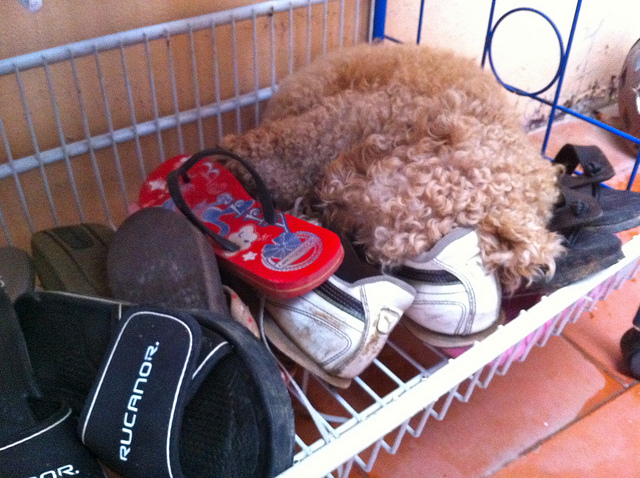

In [21]:
image_id = 42
input_image_file = os.path.join(root, 'val2014', df_images[df_images['id']==image_id]['file_name'].values[0])
input_tensor = Image.open(input_image_file)
input_tensor

In [22]:
input_tensor = np.array(input_tensor).transpose([2, 0, 1]) / 255.0
input_tensor = [torch.from_numpy(input_tensor.astype(np.float32)).clone().to(device)]

In [23]:
input_tensor

[tensor([[[0.6863, 0.6431, 0.6235,  ..., 0.9961, 0.9961, 0.9961],
          [0.6784, 0.6706, 0.6902,  ..., 0.9961, 0.9961, 0.9961],
          [0.6941, 0.6510, 0.6510,  ..., 0.9961, 0.9961, 0.9961],
          ...,
          [0.0863, 0.1333, 0.1059,  ..., 0.9137, 0.9725, 0.9686],
          [0.1608, 0.1529, 0.0863,  ..., 0.9490, 0.9490, 0.9451],
          [0.1294, 0.0980, 0.0980,  ..., 0.9922, 0.8902, 0.9490]],
 
         [[0.5451, 0.5020, 0.4745,  ..., 1.0000, 1.0000, 1.0000],
          [0.5373, 0.5294, 0.5412,  ..., 1.0000, 1.0000, 1.0000],
          [0.5608, 0.5098, 0.5098,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.1059, 0.1647, 0.1373,  ..., 0.5725, 0.6235, 0.6196],
          [0.1922, 0.1882, 0.1255,  ..., 0.6000, 0.6000, 0.5961],
          [0.1647, 0.1373, 0.1412,  ..., 0.6431, 0.5373, 0.5961]],
 
         [[0.4980, 0.4549, 0.4314,  ..., 0.9765, 0.9765, 0.9765],
          [0.4902, 0.4824, 0.4980,  ..., 0.9765, 0.9765, 0.9765],
          [0.5137, 0.4627, 0.4627,  ...,

In [24]:
predictions = model(input_tensor)

In [25]:
predictions

[{'boxes': tensor([[2.1857e+02, 6.2546e+01, 5.7242e+02, 3.1919e+02],
          [2.2041e+02, 5.8961e+01, 5.7994e+02, 3.1353e+02],
          [4.7997e+02, 3.6559e+02, 6.3913e+02, 4.7800e+02],
          [6.9701e+01, 7.6534e+01, 6.1844e+02, 4.4390e+02],
          [5.4548e+02, 3.4708e+02, 6.4000e+02, 4.5335e+02],
          [1.0257e+02, 5.9410e+01, 6.0475e+02, 4.3006e+02],
          [1.5885e+02, 1.5843e+02, 3.4234e+02, 3.0818e+02],
          [4.1520e+02, 2.7105e+02, 6.3735e+02, 4.7800e+02],
          [5.1812e+00, 3.8004e+02, 1.2003e+02, 4.7800e+02],
          [1.0257e+02, 5.9410e+01, 6.0475e+02, 4.3006e+02],
          [5.6983e+01, 2.6104e+02, 3.0310e+02, 4.7773e+02],
          [5.3337e+02, 3.3830e+02, 6.3702e+02, 4.0165e+02],
          [5.1642e+02, 3.7000e+02, 6.3894e+02, 4.2602e+02],
          [5.6519e+02, 3.0748e+02, 6.3782e+02, 4.2621e+02],
          [5.0455e+02, 1.9047e+02, 6.3087e+02, 3.1227e+02],
          [3.5817e+02, 0.0000e+00, 3.7981e+02, 4.2988e+01],
          [4.9219e+02, 3.8035e+

In [26]:
boxes = predictions[0]['boxes'].cpu().detach().numpy()
scores = predictions[0]['scores'].cpu().detach().numpy()
labels = predictions[0]['labels'].cpu().detach().numpy()

In [27]:
x1, y1, x2, y2 = boxes[0].astype(int)

In [28]:
df_images.iloc[0]['id']

391895

In [29]:
df_annotations[df_annotations['image_id']==image_id]['bbox']

125153    [214.15, 41.29, 348.26, 243.78]
Name: bbox, dtype: object

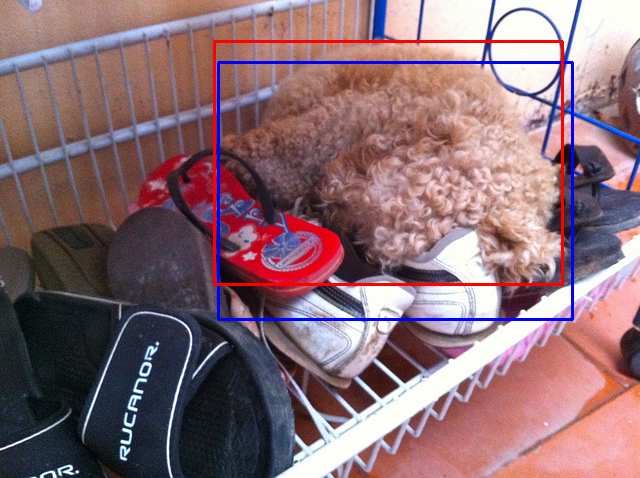

In [39]:
image = cv2.imread(input_image_file)

# --- Blue rectangle is prediction ---
category_id_preds = []
for box, score, label in zip(boxes, scores, labels):
    if (score > 0.3):
        x1, y1, x2, y2 = box.astype(int)
        image = cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), thickness=2)
        category_id_preds.append(label)

# --- Red rectangle is ground-truth ---
category_id_gt = []
for box, label in zip(df_annotations[df_annotations['image_id']==image_id]['bbox'], df_annotations[df_annotations['image_id']==image_id]['category_id']):
    x1, y1, w, h = np.array(box).astype(int)
    x2 = x1 + w
    y2 = y1 + h
    image = cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), thickness=2)
    category_id_gt.append(label)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
pil_image = Image.fromarray(image)
pil_image

In [42]:
print(f'category_id(GT): {category_id_gt}')
print(f'category_id(Preds): {category_id_preds}')

category_id(GT): [18]
category_id(Preds): [18]


In [47]:
predictions = []
for image_file in tqdm(df_images['file_name']):
    input_image_file = os.path.join(root, 'val2014', image_file)
    input_tensor = Image.open(input_image_file).convert('RGB')
    #print(f'image_file: {image_file}, shape: {np.array(input_tensor).shape}')
    input_tensor = np.array(input_tensor).transpose([2, 0, 1]) / 255.0
    input_tensor = [torch.from_numpy(input_tensor.astype(np.float32)).clone().to(device)]

    prediction = model(input_tensor)
    
    predictions += [{key: value.cpu().detach().numpy() for key, value in prediction[0].items()}]

100% 40504/40504 [50:19<00:00, 13.41it/s] 


In [48]:
len(predictions)

40504

In [49]:
predictions[0]

{'boxes': array([[3.43777466e+02, 2.45068550e+01, 4.48705261e+02, 2.87623993e+02],
        [3.56407745e+02, 1.45249512e+02, 4.97793549e+02, 3.24908203e+02],
        [3.79100372e+02, 1.38183121e+02, 4.66514893e+02, 1.94588715e+02],
        [3.56407745e+02, 1.45249512e+02, 4.97793549e+02, 3.24908203e+02],
        [3.79100372e+02, 1.38183121e+02, 4.66514893e+02, 1.94588715e+02],
        [3.59742676e+02, 8.86559753e+01, 4.90120270e+02, 3.16782959e+02],
        [3.45104614e+02, 1.57177444e+02, 3.82341461e+02, 2.73573761e+02],
        [4.71961365e+02, 1.75832428e+02, 5.18143005e+02, 2.19552933e+02],
        [3.70168610e+02, 2.21127167e+02, 4.35160461e+02, 3.16092316e+02],
        [3.66584625e+02, 1.59269043e+02, 4.02259369e+02, 1.94397324e+02],
        [2.92344360e+02, 1.52369843e+02, 3.62574432e+02, 1.87688690e+02],
        [4.22564575e+02, 1.45799103e+02, 4.88569641e+02, 2.13195709e+02],
        [2.24244957e+01, 1.66004593e+02, 2.60512024e+02, 1.94963821e+02],
        [3.37197540e+02, 2.29

In [50]:
image_ids = df_images['id'].to_list()
image_ids

[391895,
 522418,
 184613,
 318219,
 554625,
 397133,
 574769,
 60623,
 309022,
 5802,
 222564,
 118113,
 193271,
 224736,
 483108,
 403013,
 374628,
 328757,
 384213,
 293802,
 86408,
 37777,
 372938,
 386164,
 223648,
 204805,
 113588,
 384553,
 337264,
 368402,
 12448,
 252219,
 79841,
 87038,
 174482,
 515289,
 562150,
 542145,
 412151,
 403385,
 579003,
 540186,
 242611,
 51191,
 269105,
 294832,
 462565,
 144941,
 173350,
 60760,
 324266,
 166532,
 262284,
 360772,
 6818,
 191381,
 111076,
 340559,
 258985,
 509822,
 321107,
 229643,
 125059,
 455483,
 436141,
 129001,
 232262,
 61181,
 166323,
 580041,
 326781,
 387362,
 138079,
 556616,
 472621,
 192440,
 86320,
 256668,
 383445,
 565797,
 81922,
 50125,
 364521,
 394892,
 1146,
 310391,
 97434,
 463836,
 241876,
 156832,
 480985,
 458054,
 270721,
 462341,
 310103,
 32992,
 122851,
 540763,
 331352,
 138246,
 197254,
 32907,
 251252,
 37675,
 159537,
 268556,
 271177,
 75051,
 549399,
 85160,
 559665,
 296649,
 19358,
 459912,

In [78]:
results = []
score_th = 0.3
for prediction, image_id in tqdm(zip(predictions, image_ids)):
    result = [{'image_id': image_id, 'category_id': int(category_id), 'bbox': [float(bbox[0]), float(bbox[1]), float(bbox[2]-bbox[0]), float(bbox[3]-bbox[1])], 'score': float(score)} for category_id, bbox, score in zip(prediction['labels'][prediction['scores']>score_th], prediction['boxes'][prediction['scores']>score_th], prediction['scores'][prediction['scores']>score_th])]
    results += result

40504it [00:00, 67346.97it/s]


In [79]:
len(results)

140076

In [80]:
results[0:5]

[{'image_id': 391895,
  'category_id': 1,
  'bbox': [343.7774658203125,
   24.506855010986328,
   104.92779541015625,
   263.11712646484375],
  'score': 0.5371876955032349},
 {'image_id': 391895,
  'category_id': 4,
  'bbox': [356.4077453613281,
   145.24951171875,
   141.38580322265625,
   179.65869140625],
  'score': 0.48089542984962463},
 {'image_id': 391895,
  'category_id': 27,
  'bbox': [379.1003723144531,
   138.18312072753906,
   87.41452026367188,
   56.40559387207031],
  'score': 0.44558990001678467},
 {'image_id': 522418,
  'category_id': 1,
  'bbox': [371.3927917480469,
   36.167335510253906,
   268.6072692871094,
   441.1793212890625],
  'score': 0.9350480437278748},
 {'image_id': 184613,
  'category_id': 28,
  'bbox': [103.4002685546875,
   37.839805603027344,
   168.54434204101562,
   119.63481903076172],
  'score': 0.9667178392410278}]

In [81]:
type(results[0]['image_id'])

int

In [82]:
type(results[0]['bbox'])

list

In [83]:
type(results[0]['score'])

float

In [84]:
cocoDT = cocoGT.loadRes(results)

Loading and preparing results...
DONE (t=3.09s)
creating index...
index created!


## Evaluation

In [85]:
imgIds=sorted(cocoGT.getImgIds())
cocoEval = COCOeval(cocoGT, cocoDT, 'bbox')
cocoEval.params.imgIds = imgIds
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=63.49s).
Accumulating evaluation results...
DONE (t=10.44s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.241
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.358
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.273
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.238
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.464
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.212
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.271
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.272
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.015
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1

In [64]:
!wget https://github.com/cocodataset/cocoapi/raw/master/results/instances_val2014_fakebbox100_results.json

--2024-05-06 00:55:33--  https://github.com/cocodataset/cocoapi/raw/master/results/instances_val2014_fakebbox100_results.json
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/cocodataset/cocoapi/master/results/instances_val2014_fakebbox100_results.json [following]
--2024-05-06 00:55:34--  https://raw.githubusercontent.com/cocodataset/cocoapi/master/results/instances_val2014_fakebbox100_results.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60041 (59K) [text/plain]
Saving to: ‘instances_val2014_fakebbox100_results.json.2’

instances_val2014_f 100%[===================>]  58.63K  --.-KB/s   

In [65]:
coco_dummyDT = cocoGT.loadRes('instances_val2014_fakebbox100_results.json')

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!


In [66]:
imgIds=sorted(cocoGT.getImgIds())
imgIds=imgIds[0:100]
cocoEval = COCOeval(cocoGT, coco_dummyDT, 'bbox')
cocoEval.params.imgIds = imgIds
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.18s).
Accumulating evaluation results...
DONE (t=0.24s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.505
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.697
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.573
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.586
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.519
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.501
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.387
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.594
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.595
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.640
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100

In [67]:
with open('instances_val2014_fakebbox100_results.json', 'r') as f:
    dummy_results = json.load(f)

In [68]:
dummy_results

[{'image_id': 42,
  'category_id': 18,
  'bbox': [258.15, 41.29, 348.26, 243.78],
  'score': 0.236},
 {'image_id': 73,
  'category_id': 11,
  'bbox': [61, 22.75, 504, 609.67],
  'score': 0.318},
 {'image_id': 73,
  'category_id': 4,
  'bbox': [12.66, 3.32, 268.6, 271.91],
  'score': 0.726},
 {'image_id': 74,
  'category_id': 18,
  'bbox': [87.87, 276.25, 296.42, 103.18],
  'score': 0.546},
 {'image_id': 74,
  'category_id': 2,
  'bbox': [0, 3.66, 142.15, 312.4],
  'score': 0.3},
 {'image_id': 74,
  'category_id': 1,
  'bbox': [296.55, 93.96, 18.42, 58.83],
  'score': 0.407},
 {'image_id': 74,
  'category_id': 1,
  'bbox': [328.94, 97.05, 13.55, 25.93],
  'score': 0.611},
 {'image_id': 74,
  'category_id': 1,
  'bbox': [356.62, 95.47, 15.71, 52.08],
  'score': 0.335},
 {'image_id': 74,
  'category_id': 1,
  'bbox': [464.08, 105.09, 31.66, 41.9],
  'score': 0.805},
 {'image_id': 74,
  'category_id': 1,
  'bbox': [276.11, 103.84, 15.33, 46.88],
  'score': 0.953},
 {'image_id': 74,
  'cate

In [69]:
df_dummy_results = pd.DataFrame(dummy_results)
df_dummy_results

,image_id,category_id,bbox,score
0,42,18,"[258.15, 41.29, 348.26, 243.78]",0.236
1,73,11,"[61, 22.75, 504, 609.67]",0.318
2,73,4,"[12.66, 3.32, 268.6, 271.91]",0.726
3,74,18,"[87.87, 276.25, 296.42, 103.18]",0.546
4,74,2,"[0, 3.66, 142.15, 312.4]",0.300
...,...,...,...,...
729,1292,62,"[160.71, 189.99, 325.29, 231.25]",0.779
730,1292,41,"[45.23, 47.68, 359.98, 379.32]",0.626
731,1292,1,"[0, 205.05, 28.62, 193.83]",0.594
732,1292,43,"[193.26, 44.14, 222.62, 256.2]",0.997
